In [32]:
!pip install catboost


In [57]:
# === Базовые библиотеки ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Предобработка данных ===
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# === Модели машинного обучения ===
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# === Метрики оценки моделей ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Статистический анализ ===
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


In [34]:
# Загрузка данных
data = pd.read_csv('insurance.csv')

print(data.head())
print(data.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


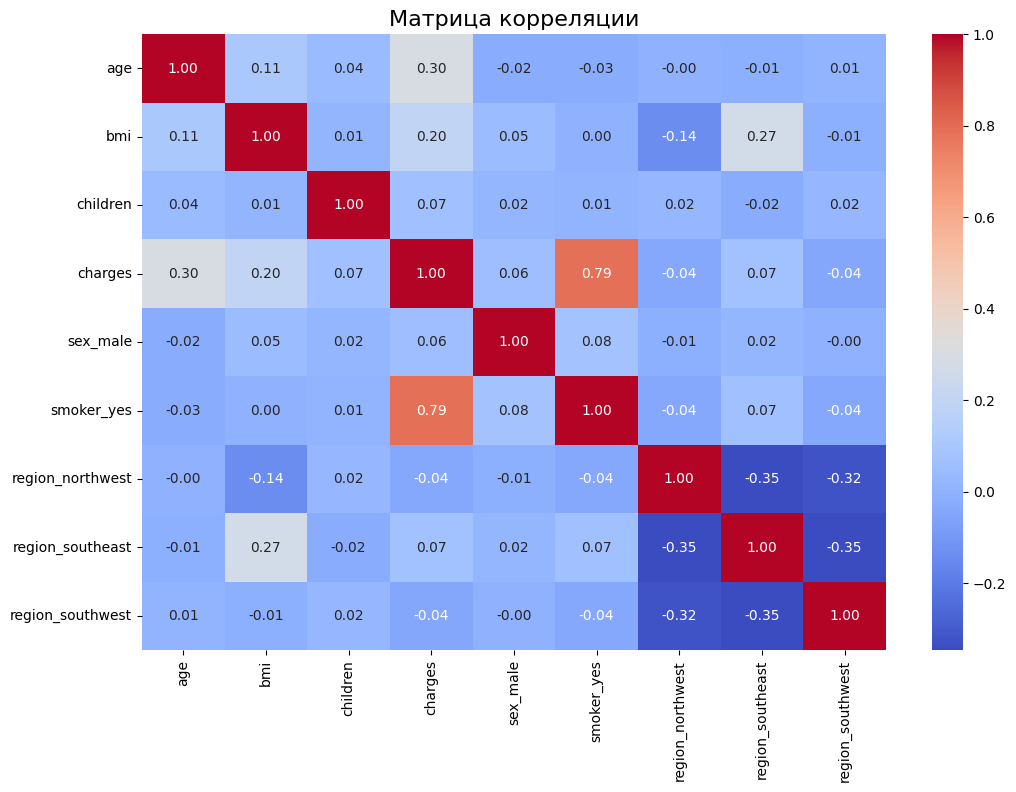

In [35]:
# Преобразование категориальных переменных в числовые
categorical_columns = ['sex', 'smoker', 'region']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Построение матрицы корреляции
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Матрица корреляции", fontsize=16)
plt.show()

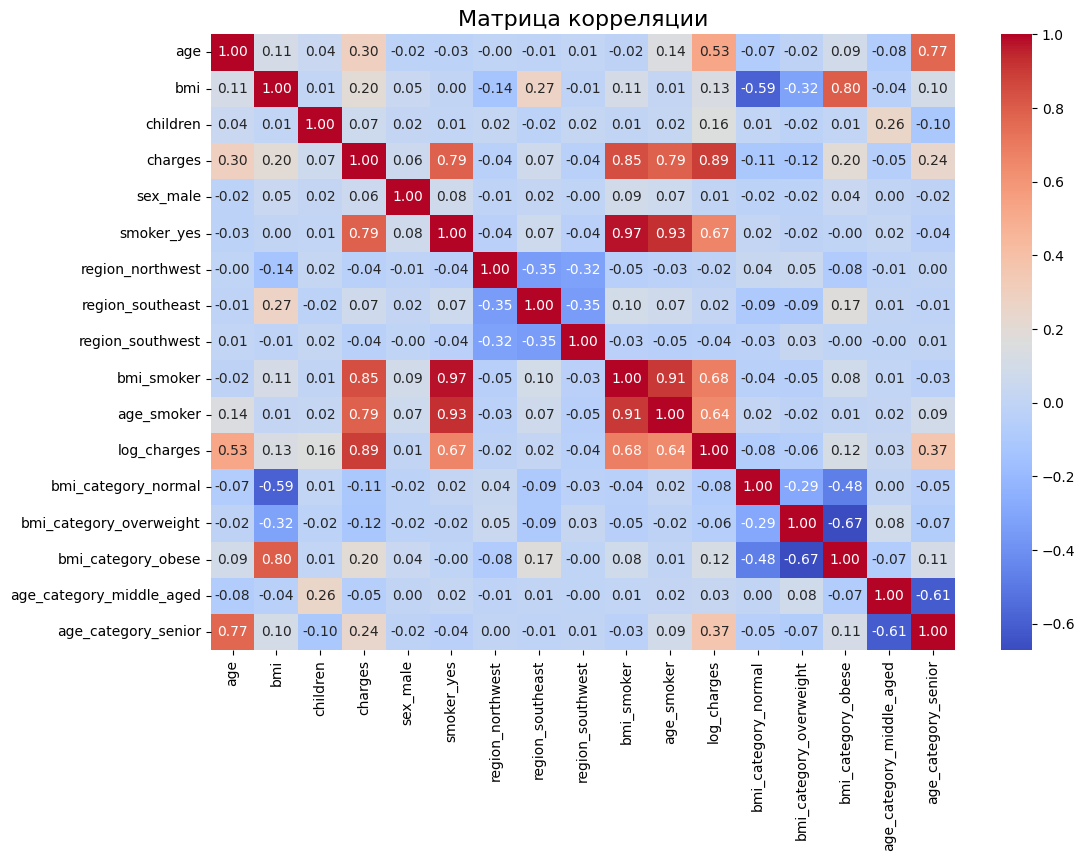

In [36]:
# Добавление новых признаков
data['bmi_smoker'] = data['bmi'] * data['smoker_yes']  # Взаимодействие BMI и курения
data['age_smoker'] = data['age'] * data['smoker_yes']  # Взаимодействие возраста и курения

# Категоризация возраста
data['age_category'] = pd.cut(data['age'], bins=[0, 25, 50, 100], labels=['young', 'middle_aged', 'senior'])

# Категоризация BMI
data['bmi_category'] = pd.cut(
    data['bmi'], bins=[0, 18.5, 25, 30, 100],
    labels=['underweight', 'normal', 'overweight', 'obese']
)

# Логарифмическое преобразование целевой переменной
data['log_charges'] = np.log1p(data['charges'])

# Преобразование категориальных переменных в числовые
data = pd.get_dummies(data, columns=['bmi_category', 'age_category'], drop_first=True)

# Построение матрицы корреляции
corr_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Матрица корреляции", fontsize=16)
plt.show()

In [37]:
X_vif = data.drop(columns=['charges', 'log_charges'])
X_vif = X_vif.select_dtypes(include=[np.number])

# Добавление константы для расчета VIF
X_vif = add_constant(X_vif)

# Расчет VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Проверка мультиколлинеарности (VIF):")
print(vif_data)

Проверка мультиколлинеарности (VIF):
      Feature        VIF
0       const  31.976038
1         age   1.231557
2         bmi   1.105436
3    children   1.002443
4  bmi_smoker   7.190010
5  age_smoker   7.251538


In [38]:
# Определение целевой переменной и признаков
y = data['log_charges']
X = data.drop(columns=['charges', 'log_charges'])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
numeric_columns = ['age', 'bmi', 'children', 'bmi_smoker', 'age_smoker',]
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [39]:
# Модели и их гиперпараметры для Grid Search
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [500, 750, 1000],  
            'max_depth': [4, 5, 6],  
            'min_samples_split': [2, 5, 10], 
            'min_samples_leaf': [1, 2, 4],  
            'bootstrap': [True, False]  
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300, 500], 
            'learning_rate': [0.01, 0.03, 0.05],  
            'max_depth': [2, 3, 4],  
            'subsample': [0.6, 0.8, 1.0],  
            'colsample_bytree': [0.6, 0.8, 1.0],  
            'gamma': [0, 0.1, 0.2, 0.5, 1.0]  
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=0),
        'params': {
            'iterations': [500, 1000, 1500], 
            'learning_rate': [0.005, 0.01, 0.05],  
            'depth': [3, 4, 5], 
            'l2_leaf_reg': [1, 3, 5, 7],
            'bagging_temperature': [0.0, 0.5, 1.0, 2.0] 
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'num_leaves': [31, 50, 100],
            'min_child_samples': [20, 30, 50],
            'min_split_gain': [0.1, 0.2, 0.5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    },
    'PolynomialRegression': {
    'model': Pipeline([
        ('poly', PolynomialFeatures()),  
        ('linear', LinearRegression())  
    ]),
    'params': {
        # Параметры PolynomialFeatures
        'poly__degree': [2, 3, 4],  
        'poly__interaction_only': [False, True],  
        'poly__include_bias': [True, False], 
        'poly__order': ['C', 'F'],  

        # Параметры LinearRegression
        'linear__fit_intercept': [True, False],  
        'linear__copy_X': [True, False],  
        'linear__n_jobs': [None, 1, 2, 4],  
        'linear__positive': [False, True]  

        }
    }
}


In [40]:
best_models = {}
for name, config in models.items():
    print(f"Обучение модели: {name}")
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Лучшие параметры {name}: {grid.best_params_}")

Обучение модели: RandomForest
Лучшие параметры RandomForest: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Обучение модели: XGBoost
Лучшие параметры XGBoost: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Обучение модели: CatBoost
Лучшие параметры CatBoost: {'bagging_temperature': 0.0, 'depth': 5, 'iterations': 1500, 'l2_leaf_reg': 5, 'learning_rate': 0.005}
Обучение модели: LightGBM
Лучшие параметры LightGBM: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 30, 'min_split_gain': 0.2, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.6}
Обучение модели: PolynomialRegression
Лучшие параметры PolynomialRegression: {'linear__copy_X': True, 'linear__fit_intercept': True, 'linear__n_jobs': None, 'linear__positive': False, 'poly__degree': 2, 'poly__include_bias': True, 'poly__interaction_only': True, 'poly__order': 'C'}


In [41]:
# Оценка каждой модели на тестовых данных
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
    mse = mean_squared_error(y_test, y_pred)  # MSE
    mae = mean_absolute_error(y_test, y_pred)  # MAE
    r2 = r2_score(y_test, y_pred)  # R²

    print(f"Модель: {name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 40)

Модель: RandomForest
  RMSE: 0.3527
  MSE: 0.1244
  MAE: 0.1939
  R²: 0.8616
----------------------------------------
Модель: XGBoost
  RMSE: 0.3448
  MSE: 0.1189
  MAE: 0.1866
  R²: 0.8678
----------------------------------------
Модель: CatBoost
  RMSE: 0.3450
  MSE: 0.1190
  MAE: 0.1848
  R²: 0.8676
----------------------------------------
Модель: LightGBM
  RMSE: 0.3507
  MSE: 0.1230
  MAE: 0.1908
  R²: 0.8631
----------------------------------------
Модель: PolynomialRegression
  RMSE: 0.3624
  MSE: 0.1313
  MAE: 0.1966
  R²: 0.8539
----------------------------------------


In [49]:
# Создание ансамбля
ensemble = VotingRegressor(estimators=[
    ('RandomForest', best_models['RandomForest']),
    ('XGBoost', best_models['XGBoost']),
    ('CatBoost', best_models['CatBoost']),
    ('LightGBM', best_models['LightGBM']),
    ('PolynomialRegression', best_models['PolynomialRegression']) 
], weights=[2, 4, 3, 3, 1])  # Веса

In [50]:
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('RandomForest',
                             RandomForestRegressor(max_depth=5,
                                                   min_samples_leaf=4,
                                                   n_estimators=500,
                                                   random_state=42)),
                            ('XGBoost',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, fea...
                                          random_state=42, ...)),
                            ('CatBoost',
                             <catboost.core.CatBoostRegressor object at 0x7af0421386d0>),
                            ('LightGBM',
                             LGBMRegressor(max_depth=3, min_child_samples=30,
                                           min_split_gain=0.2, random_state=42,
                                           subsample=0.6, verbose=-1)),
                            ('PolynomialRegression',
                             Pipeline(steps=[('poly',
                                              PolynomialFeatures(interaction_only=True)),
                                             ('linear', LinearRegression())]))],
                weights=[2, 4, 3, 3, 1])

In [51]:
# Оценка ансамбля
y_pred_ensemble = ensemble.predict(X_test)

# Метрики
rmse_ensemble = mean_squared_error(y_test, y_pred_ensemble) ** 0.5  
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)  
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)  
r2_ensemble = r2_score(y_test, y_pred_ensemble)  

# Вывод результатов
print("Ансамбль:")
print(f"  RMSE: {rmse_ensemble:.4f}")
print(f"  MSE: {mse_ensemble:.4f}")
print(f"  MAE: {mae_ensemble:.4f}")
print(f"  R²: {r2_ensemble:.4f}")

Ансамбль:
  RMSE: 0.3452
  MSE: 0.1192
  MAE: 0.1837
  R²: 0.8674


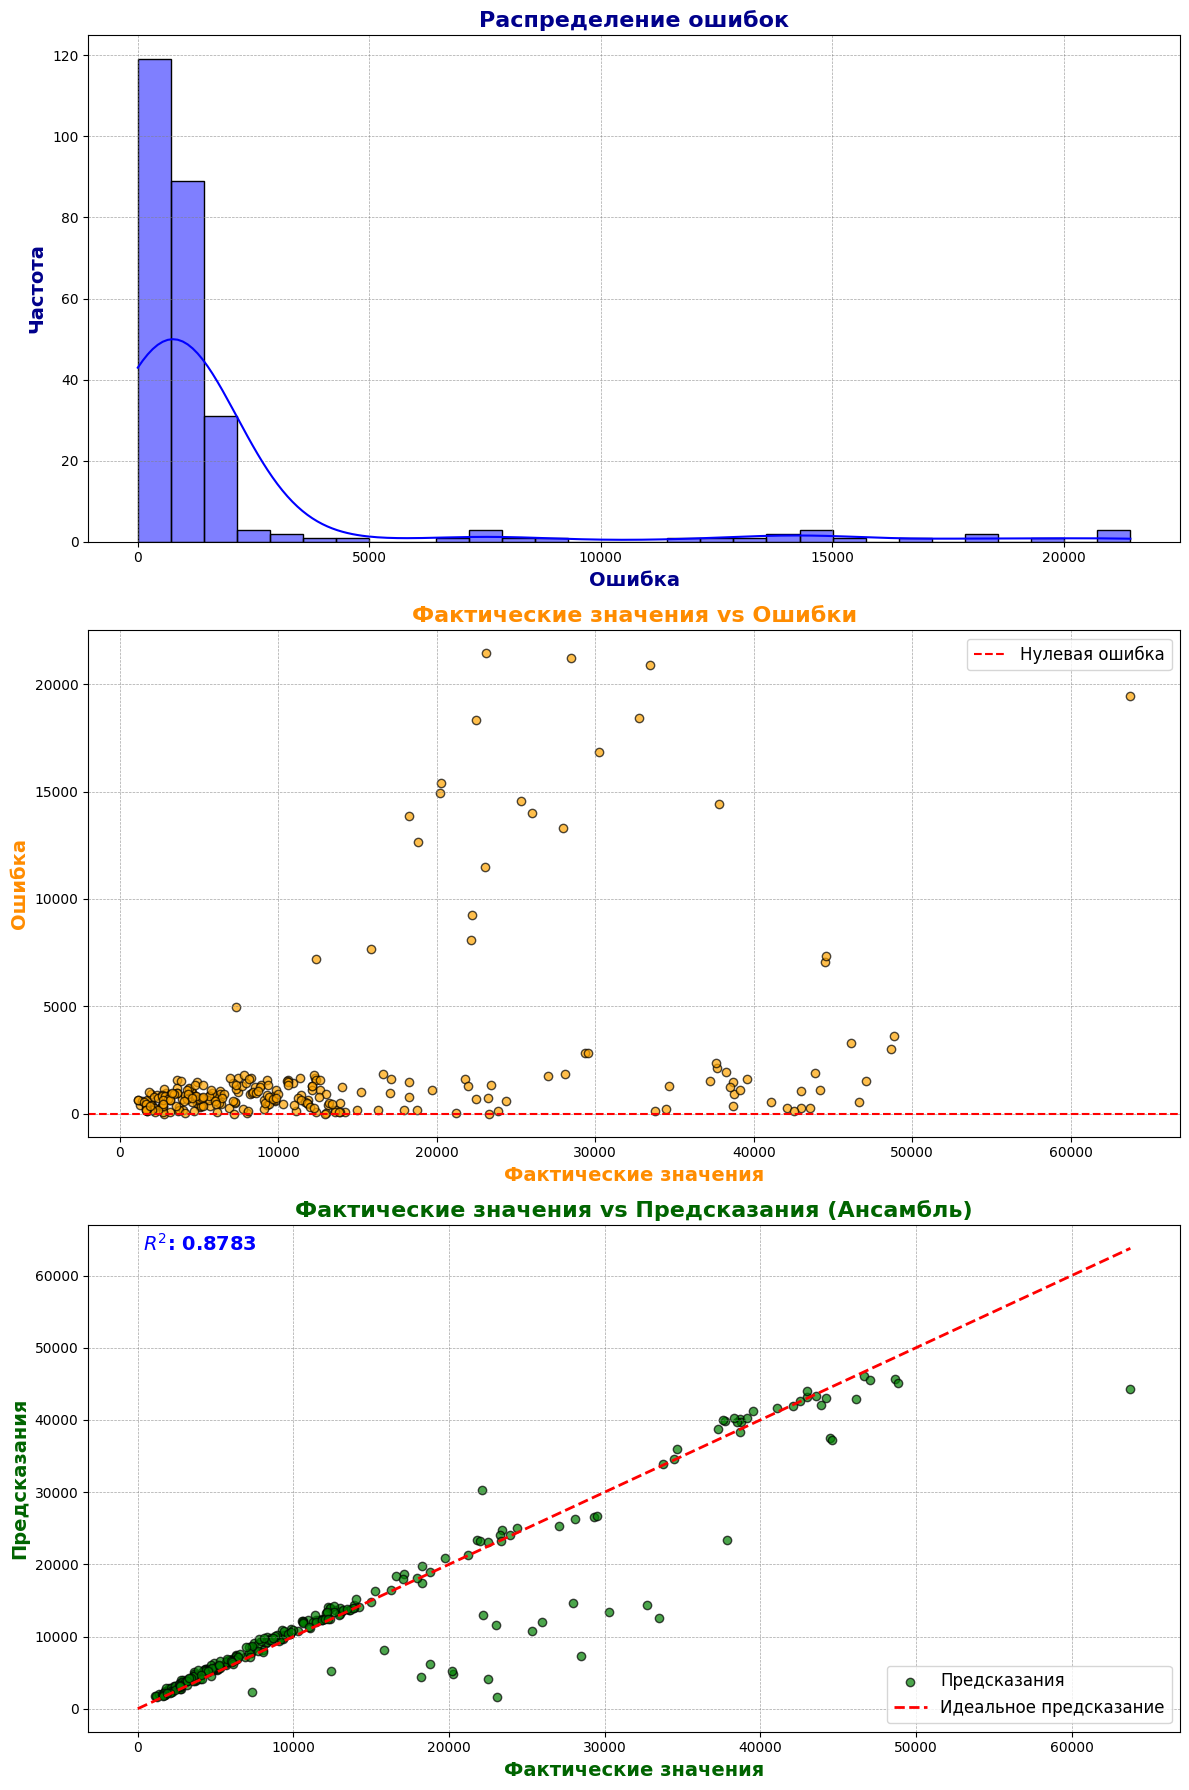

Тест Шапиро-Уилка: p-value = 0.0000
Тест Бреуша-Пагана: p-value = 0.7537
Статистика Дарбина-Уотсона: 2.1434


In [55]:
test_df = pd.DataFrame({
    'charges': np.expm1(y_test),  
    'predicted': np.expm1(y_pred_ensemble)  
})

# Вычисление ошибок
test_df['error'] = abs(test_df['charges'] - test_df['predicted'])  
test_df['residuals'] = test_df['charges'] - test_df['predicted']  

fig, axes = plt.subplots(3, 1, figsize=(12, 18))  

# 1. Распределение ошибок
sns.histplot(test_df['error'], kde=True, bins=30, color='blue', edgecolor='black', ax=axes[0])
axes[0].set_title('Распределение ошибок', fontsize=16, fontweight='bold', color='darkblue')
axes[0].set_xlabel('Ошибка', fontsize=14, fontweight='bold', color='darkblue')
axes[0].set_ylabel('Частота', fontsize=14, fontweight='bold', color='darkblue')
axes[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# 2. Фактические значения vs Ошибки
axes[1].scatter(test_df['charges'], test_df['error'], alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title('Фактические значения vs Ошибки', fontsize=16, fontweight='bold', color='darkorange')
axes[1].set_xlabel('Фактические значения', fontsize=14, fontweight='bold', color='darkorange')
axes[1].set_ylabel('Ошибка', fontsize=14, fontweight='bold', color='darkorange')
axes[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Нулевая ошибка')
axes[1].legend(fontsize=12)

# 3. Фактические значения vs Предсказания (Ансамбль)
axes[2].scatter(test_df['charges'], test_df['predicted'], alpha=0.7, color='green', edgecolor='black', label='Предсказания')
axes[2].plot([0, max(test_df['charges'])], [0, max(test_df['charges'])], color='red', linestyle='--', linewidth=2, label='Идеальное предсказание')


r2 = r2_score(test_df['charges'], test_df['predicted'])


axes[2].text(0.05, 0.95, f"$R^2$: {r2:.4f}", transform=axes[2].transAxes, fontsize=14, color='blue', fontweight='bold')

axes[2].set_title('Фактические значения vs Предсказания (Ансамбль)', fontsize=16, fontweight='bold', color='darkgreen')
axes[2].set_xlabel('Фактические значения', fontsize=14, fontweight='bold', color='darkgreen')
axes[2].set_ylabel('Предсказания', fontsize=14, fontweight='bold', color='darkgreen')
axes[2].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
axes[2].legend(fontsize=12)

plt.tight_layout()

plt.show()

# Тест Шапиро-Уилка на нормальность
shapiro_test = shapiro(test_df['residuals'])
print(f"Тест Шапиро-Уилка: p-value = {shapiro_test.pvalue:.4f}")

# Тест Бреуша-Пагана на гетероскедастичность
# Добавляем константу в exog
exog = add_constant(test_df[['predicted']])
_, pval, _, _ = het_breuschpagan(test_df['residuals'], exog)
print(f"Тест Бреуша-Пагана: p-value = {pval:.4f}")

# Тест Дарбина-Уотсона на автокорреляцию
dw_stat = durbin_watson(test_df['residuals'])
print(f"Статистика Дарбина-Уотсона: {dw_stat:.4f}")